In [ ]:
from nbdev import *
%nbdev_default_export lightcurve
%load_ext autoreload
from nbdev.showdoc import show_doc
!date

Cells will be exported to wtlike.lightcurve,
unless a different module is specified after an export flag: `%nbdev_export special.module`
Wed May  5 16:21:00 PDT 2021


# Light Curve Generation
> Generate light curves from cells

A "light curve" is a table with columns

- `t` -- time in MJD 
- `tw` -- the cell width
- `n`  -- number of photons
- `e`  -- relative exposure
- `fit` -- the fit object, containing info about the flux. This is usually a `PoissonRep` object

It is generated from a set of cells

Implemented here:

- `get_LightCurve`
- `fit_cells`
- `flux_plot`

In [ ]:
%nbdev_export
import numpy as np
import pylab as plt
import pandas as pd
from wtlike.config import *
from wtlike.loglike import (LogLike, GaussianRep, Gaussian2dRep, PoissonRep, PoissonRepTable)
from wtlike.cell_data import *

In [ ]:
%nbdev_export
class _LightCurve(object):
    """ Apply likelihood fits to a set of cells
    
    parameters:
       - cells : a table with index t, columns  tw, n, e, w, S, B
       - min_exp : minimum fractional exposure allowed
       - rep_name : represention to use 

    Generates a DataFrame with columns n, ep, fit
        
    """

    rep_class =  [GaussianRep, Gaussian2dRep, PoissonRep, PoissonRepTable]
    rep_list =   'gauss gauss2d poisson poissontable'.split()

    def __init__(self, config, 
                all_cells, 
                source, 
                min_exp:  'minimum exposure factor'= 1e-6,
                min_n: 'minimum number of photos'= 1, 
                rep_name: 'likelihood rep name'='',
    
                ):
        """Apply fits to the likelihoods for a set of cells
        
 
        """

        self.source_name = source.name
        self.config=config
 
        # select the set of cells
        
        self.cells = cells = all_cells.query(f'e>{min_exp} & n>={min_n}').copy()
        assert len(cells)>0, 'No cells left?'
        
        # generate a list of LogLike objects for each
        cells.loc[:,'loglike'] = cells.apply(LogLike, axis=1)
        if config.verbose>0:
            print(f'Loaded {len(cells)} / {len(all_cells)} cells with at least {min_n} photons and exposure >'\
                  f' {min_exp} for light curve analysis')
            if config.verbose>1:
                print(f'first cell: {cells.iloc[0]}')

        # analyze using selected rep
        rep_name = rep_name or config.likelihood_rep
        
        if rep_name not in self.rep_list:
            raise Exception(f'Unrecognized rep: "{rep_name}", must be one of {self.rep_list}')
        repcl = self.rep_class[self.rep_list.index(rep_name)]

        if config.verbose>1:
            print(f'Fitting likelihoods with {rep_name} representation')
        
        # making output with reduced columns 
        self.ll_fits = cells['t tw n e'.split()].copy()
        try:
            self.ll_fits.loc[:,'fit'] = cells.loglike.apply(repcl)
        except Exception as e:
            print(f'Failed a fit: \n{e}', file=sys.sterr)
            raise
            

    def __repr__(self):
        return f'{self.__class__.__name__}: source "{self.source_name}" fit with {len(self.ll_fits)} cells'
    
    def full_likelihood():
        return LogLike(concatenate_cells(self.cells))

    @property
    def dataframe(self):
        """return the DataFrame
        """
        return self.ll_fits
    
#     def plot(self, **kwargs):
#         flux_plot(self.config, self, **kwargs)

In [ ]:
%nbdev_export
def fit_cells(config, 
            input_cells, 
            repcl = PoissonRep,

            ):
    """Apply fits to the likelihoods for a set of cells
    return light-curve dataframe

    """

    # select the set of cells
    cells = input_cells.copy()

    # generate a list of LogLike objects for each
    cells.loc[:,'loglike'] = cells.apply(LogLike, axis=1)
    if config.verbose>0:
        print(f'Loaded {len(cells)} / {len(input_cells)} cells for fitting')
  
    # making output with reduced columns 
    ll_fits = cells['t tw n e'.split()].copy()
    ll_fits.loc[:,'fit'] = cells.loglike.apply(repcl)
    
    return ll_fits

In [ ]:
%nbdev_export  

def get_LightCurve(config,  source, cell_query='e>1e-6',  key=''):
    """Returns a lightcurve table for the source
    
    - `source` -- a PointSource object
    - `cell query` -- query to apply to cell selection
    - `bin_edges` -- optional to select other than default described in config
    - `key` -- optional cache key. Set to None to disable cache use
    
    """
    def doit():
        cell_data = CellData(config,  source)
        cells = cell_data.df.query(cell_query)
        assert len(cells)>0, 'No cells from CellData after query'
        lc = _LightCurve(config, cells, source).dataframe
        return lc
        
#     if bin_edges is None:
        # use cache only with default bins
    key = f'lightcurve_{source.name}' if key=='' else  key 
    description = f'Light curve with {cell_query} for {source.name}' if config.verbose>0 and key is not None else '' 
    return config.cache(key, doit, description=description)
#     else:
#         return doit()

In [ ]:
%nbdev_export
def fit_table(lc, expect=1.0):
    """Generate a summary table from a light curve dataframe"""
    fits = lc.fit
    flux = fits.apply(lambda f: f.flux)
    errors = fits.apply(lambda f: (round(f.errors[0]-f.flux,3), rorebinnedund(f.errors[1]-f.flux ,3) ) )
    sigma_dev = fits.apply(lambda f: round(f.poiss.sigma_dev(expect),1) )
    df = lc['t tw n'.split()].copy() # maybe fix warnings?
    df.loc[:,'flux'] = flux.values.round(4)
    df.loc[:, 'errors'] = errors.values
    df.loc[:, 'sigma_dev'] = sigma_dev.values
    df.loc[:, 'limit'] =  fits.apply(lambda f: f.limit)
    return df

In [ ]:
%nbdev_export
def flux_plot(config, lightcurve, ts_min=4,  ts_bar_min=4,
              title=None, ax=None, fignum=1, figsize=(12,4),
              step=False, 
              tzero:'time offset'=0,
              flux_factor=1, 
              colors=('cornflowerblue','sandybrown', 'blue'), fmt=' ',
              source_name=None,
              zorder=0,
              **kwargs): 
    """Make a plot of flux vs. time
    
    - lightcurve -- lightcurve DataFrame 
    - ts_min -- threshold for ploting point
    - ts_bar_min -- threshold for plotting as bar
    - colors -- tuple of colors for signal, limit, step
    - tzero -- time offset, in MJD
    - kwargs -- apply to the Axis object
    - step   -- add a "step" plot
    - source_name -- draw text in top left
    - zorder -- set to different number to order successive calls with same Axis object
    
    returns the Figure instance
    """
    import matplotlib.ticker as ticker
    label = kwargs.pop('label', None)
    step_label = kwargs.pop('step_label', None)
    
    fig, ax = plt.subplots(figsize=figsize, num=fignum) if ax is None else (ax.figure, ax)
    kw=dict(yscale='linear',
            xlabel='MJD'+ f' - {tzero} [{UTC(tzero)[:10]}]' if tzero else '' ,
            ylabel='Relative flux')
    kw.update(**kwargs)
    ax.set(**kw)
    ax.set_title(title) # or f'{source_name}, rep {self.rep}')
    ax.grid(alpha=0.5)
    if kw['yscale']=='log':
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(
            lambda val,pos: { 1.0:'1', 10.0:'10', 100.:'100'}.get(val,'')))

    df = lightcurve.copy() #if isinstance(lightcurve, pd.DataFrame) else lightcurve.dataframe
    df.loc[:,'ts'] = df.fit.apply(lambda f: f.ts) 
    df = df.query(f'ts>={ts_min}')
    
    rep = config.likelihood_rep
    if rep =='poisson':

        limit = df.ts<ts_bar_min
        bar = df.loc[~limit,:]
        lim = df.loc[limit,:]
        allflux= np.select([~limit, limit], 
                        [df.fit.apply(lambda f: f.flux).values,
                         df.fit.apply(lambda f: f.limit).values],
                       )* flux_factor
    else: 
        bar=df; lim=[]

    
    # do the limits first (only for poisson rep)
    error_size=2
    if len(lim)>0:
        t = lim.t-tzero
        tw = lim.tw 

        y = allflux[limit] 
        yerr=0.2*(1 if kw['yscale']=='linear' else y)*flux_factor
        ax.errorbar(x=t, y=y, xerr=tw/2,
                yerr=yerr,  color=colors[2 if step else 1] , 
                uplims=True, ls='', lw=error_size, capsize=2*error_size, capthick=0,
                zorder=zorder,
               )
    
    # then the points with error bars
    t = bar.t.values-tzero
    tw = bar.tw.values.astype(float) 
    fluxmeas = allflux[~limit]
    upper = bar.fit.apply(lambda f: f.errors[1]).values * flux_factor
    lower = bar.fit.apply(lambda f: f.errors[0]).values * flux_factor
    error = np.array([upper-fluxmeas, fluxmeas-lower])
    if label is None:
        label = f'{bin_size_name(round(tw.mean(),4))} bins' if np.std(tw)<1e-6 else ''
    ax.errorbar(x=t, xerr=tw/2, y=fluxmeas, yerr=error, lw=2, fmt=fmt, color=colors[0], label=label,
               zorder=zorder+1)
    
    # finally ovelay the step if requested
    if step:
        t = df.t.values-tzero
        xerr = df.tw.values/2; 
        x = np.append(t-xerr, [t[-1]+xerr[-1]]); 
        y = np.append(allflux, [allflux[-1]])
        ax.step(x, y, color=colors[2], where='post', lw=2, label=step_label, 
               zorder=zorder+2)
        
    # the legend: if added overplot, make sure it is below
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1],loc='upper left', fontsize=12, frameon=False)

    if source_name is not None:
        ax.text(0.99, 0.9, source_name, transform=ax.transAxes, ha='right' )
    return fig

In [ ]:
show_doc(flux_plot)

<h4 id="flux_plot" class="doc_header"><code>flux_plot</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>flux_plot</code>(**`config`**, **`lightcurve`**, **`ts_min`**=*`4`*, **`ts_bar_min`**=*`4`*, **`title`**=*`None`*, **`ax`**=*`None`*, **`fignum`**=*`1`*, **`figsize`**=*`(12, 4)`*, **`step`**=*`False`*, **`tzero`**:`time offset`=*`0`*, **`flux_factor`**=*`1`*, **`colors`**=*`('cornflowerblue', 'sandybrown', 'blue')`*, **`fmt`**=*`' '`*, **`source_name`**=*`None`*, **`zorder`**=*`0`*, **\*\*`kwargs`**)

Make a plot of flux vs. time

- lightcurve -- lightcurve DataFrame 
- ts_min -- threshold for ploting point
- ts_bar_min -- threshold for plotting as bar
- colors -- tuple of colors for signal, limit, step
- tzero -- time offset, in MJD
- kwargs -- apply to the Axis object
- step   -- add a "step" plot
- source_name -- draw text in top left
- zorder -- set to different number to order successive calls with same Axis object

returns the Figure instance

Example plot-- the first 100 days of Fermi data for Geminga

And forcing upper limits

In [ ]:
#collapse_hide
config=Config()
# fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4), sharex=True, sharey=True)
# flux_plot(config, lc.lc_df, ax=ax1, fmt='o', xlim=(54689, 54700),  step=True)
# flux_plot(config, lc.lc_df, ax=ax2, fmt='o', xlim=(54689, 54700), ts_bar_min=1000, step=True, step_label='step')
# fig.set_facecolor('white');

In [ ]:
%nbdev_export
class LightCurve(CellData):
    """Full analysis of a source, 
    Inherits from `CellData`

    """
    def __init__(self, *pars, **kwargs):
        super().__init__(*pars, **kwargs)
        self.update()
        
    def update(self):
        # invoked by current, again if a copy
        # get the cells from superclass
        
        self.cells = self.df
        self.lc = _LightCurve(self.config, self.cells, self.source)
        self.lc_df = self.lc.dataframe
        
    def plot_flux(self, **kwargs):
        source_name = kwargs.pop('source_name', self.source_name)
        
        fig = flux_plot(self.config, self.lc_df, source_name=source_name, label=self.step_name+' bins', 
                        #flux_factor=getattr(self, 'exposure_factor',1) , 
                        **kwargs)
        fig.set_facecolor('white')
        return fig
    
    def plot(self, **kwargs):
        """Make a light curve plot"""
        return self.plot_flux(**kwargs)
    
    def flux_table(self, lc=None, expect=1):

        """Generate a summary table from the light curve 
        
        - lc -- A light curve dataframe; use current one if not specified
        """
        if lc is None: lc=self.lc_df
        
        fits = lc.fit
        flux = fits.apply(lambda f: f.flux)
        errors = fits.apply(lambda f: (round(f.errors[0]-f.flux,3), round(f.errors[1]-f.flux ,3) ) )
        # for future
        #sigma_dev = fits.apply(lambda f: round(f.poiss.sigma_dev(expect),1) )
        
        df = lc['t tw n'.split()].copy() # maybe fix warnings?
        df.loc[:,'flux'] = flux.values.round(4)
        df.loc[:, 'ts'] =  fits.apply(lambda f: f.ts).round(1)
        df.loc[:, 'errors'] = errors.values
        #df.loc[:, 'sigma_dev'] = sigma_dev.values
        df.loc[:, 'limit'] =  fits.apply(lambda f: f.limit)
        

        return df

In [ ]:
lc = LightCurve('Geminga')

photons and exposure for Geminga: Restoring from cache with key "Geminga__data"
LightCurve: Source Geminga with:
	 data:     1,211,364 photons from   2008-08-04 to 2021-04-28
	 exposure: 3,112,161 intervals from 2008-08-04 to 2021-04-28
Bin photon data into 664 1-week bins from 54683.0 to 59331.0
Loaded 655 / 664 cells with at least 1 photons and exposure > 1e-06 for light curve analysis


In [ ]:
lc.cells

,t,tw,e,n,w,S,B
0,54686.5,7.0,1.94e-03,2399,"[0.95343286, 0.83939403, 0.4169661, 0.68349504...",1696.38,647.66
1,54693.5,7.0,1.59e-03,1949,"[0.5989889, 0.82104284, 0.8735456, 0.66852653,...",1390.07,530.71
2,54700.5,7.0,1.39e-03,1663,"[0.47180313, 0.6512664, 0.85817957, 0.47664848...",1221.62,466.40
3,54707.5,7.0,1.45e-03,1681,"[0.49577782, 0.93275243, 0.6476385, 0.6242229,...",1267.79,484.03
4,54714.5,7.0,1.88e-03,2310,"[0.6384561, 0.96683323, 0.9358331, 0.95583063,...",1652.29,630.83
...,...,...,...,...,...,...,...
659,59299.5,7.0,1.40e-03,1664,"[0.6431231, 0.85924345, 0.9604751, 0.8692929, ...",1223.00,466.93
660,59306.5,7.0,1.12e-03,1392,"[0.9604751, 0.3464107, 0.76556027, 0.8766433, ...",985.13,376.11
661,59313.5,7.0,1.52e-03,1872,"[0.8386951, 0.95343286, 0.5842572, 0.30439377,...",1331.11,508.20
662,59320.5,7.0,1.70e-03,1999,"[0.7641368, 0.7525394, 0.8285082, 0.28474078, ...",1491.90,569.59


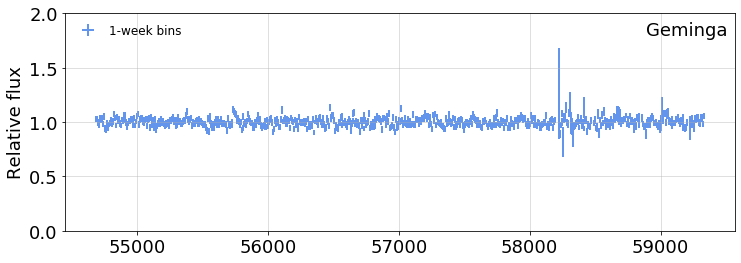

In [ ]:
lc.plot_flux(ylim=(0,2));

### Test selecting a subset with a new copy

Bin photon data into 72 10-min bins from 59325.0 to 59325.5
Loaded 25 / 72 cells with at least 1 photons and exposure > 1e-06 for light curve analysis


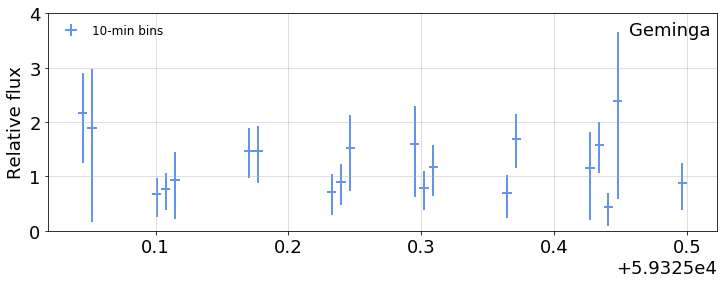

In [ ]:
lc2 = lc.view((-8,-7.5, 10/24/60))
lc2.plot_flux(ylim=(0,4), ts_min=5);

In [ ]:
lc2.flux_table().head()

,t,tw,n,flux,ts,errors,limit
4,59325.03,6.94e-03,2,0.04,0.0,"(-0.039, 0.542)",1.53
6,59325.05,6.94e-03,8,2.17,29.5,"(-0.732, 0.926)",4.05
7,59325.05,6.94e-03,2,1.89,9.1,"(-1.083, 1.734)",6.11
14,59325.10,6.94e-03,7,0.67,10.6,"(-0.305, 0.411)",1.55
15,59325.11,6.94e-03,7,0.77,18.6,"(-0.296, 0.385)",1.57


In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_effective_area.ipynb.
Converted 02_data_man.ipynb.
Converted 03_source_data.ipynb.
Converted 03_weights.ipynb.
Converted 06_poisson.ipynb.
Converted 07_cell_data.ipynb.
Converted 08_loglike.ipynb.
Converted 09_lightcurve.ipynb.
Converted 10_simulation.ipynb.
Converted 14_bayesian.ipynb.
Converted index.ipynb.
Thu May  6 08:02:04 PDT 2021
